In [39]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2,
    'lines.markersize': 8
}

plt.rcParams.update(myparams)

from utils import Dataset, Estimator, Forecaster, Visualizer
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#figures_path = "figures/"
figures_path = "figures_gray/"

In [3]:
if figures_path == "figures_gray/":
    from cycler import cycler
    monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
                  cycler('linestyle', ['-', '--', ':', '-.']))
    plt.rc('axes', prop_cycle=monochrome)
    format = "eps"
else:
    format = "pdf"

# Линейная регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2) $$

Сгенерируем синтетическую выборку

In [4]:
m = 1000
n = 20

mu = np.zeros(n)
Sigma = np.identity(n)

alpha = 1
sigma2 = 1

In [5]:
X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [6]:
dataset = Dataset(X, y)

In [7]:
B = 1000
norms = []
eigvals = []

for _ in tqdm(range(B)):
    tmp = []
    tmp_eigvals = []
    k = m - 1
    Xkp1 = X
    while k > n:
        index = np.random.randint(k)
        Xk = np.delete(Xkp1, index, axis=0)
        tmp.append(np.linalg.norm(Xkp1.T @ Xkp1 - Xk.T @ Xk))
        tmp_eigvals.append(np.linalg.eigvalsh(Xk.T @ Xk)[0])
        Xkp1 = Xk
        k -= 1
    norms.append(tmp)
    eigvals.append(tmp_eigvals)

norms = np.array(norms)
norms = norms.mean(axis=0)[::-1]
eigvals = np.array(eigvals)
eigvals = eigvals.mean(axis=0)[::-1]

100%|██████████| 1000/1000 [01:06<00:00, 14.98it/s]


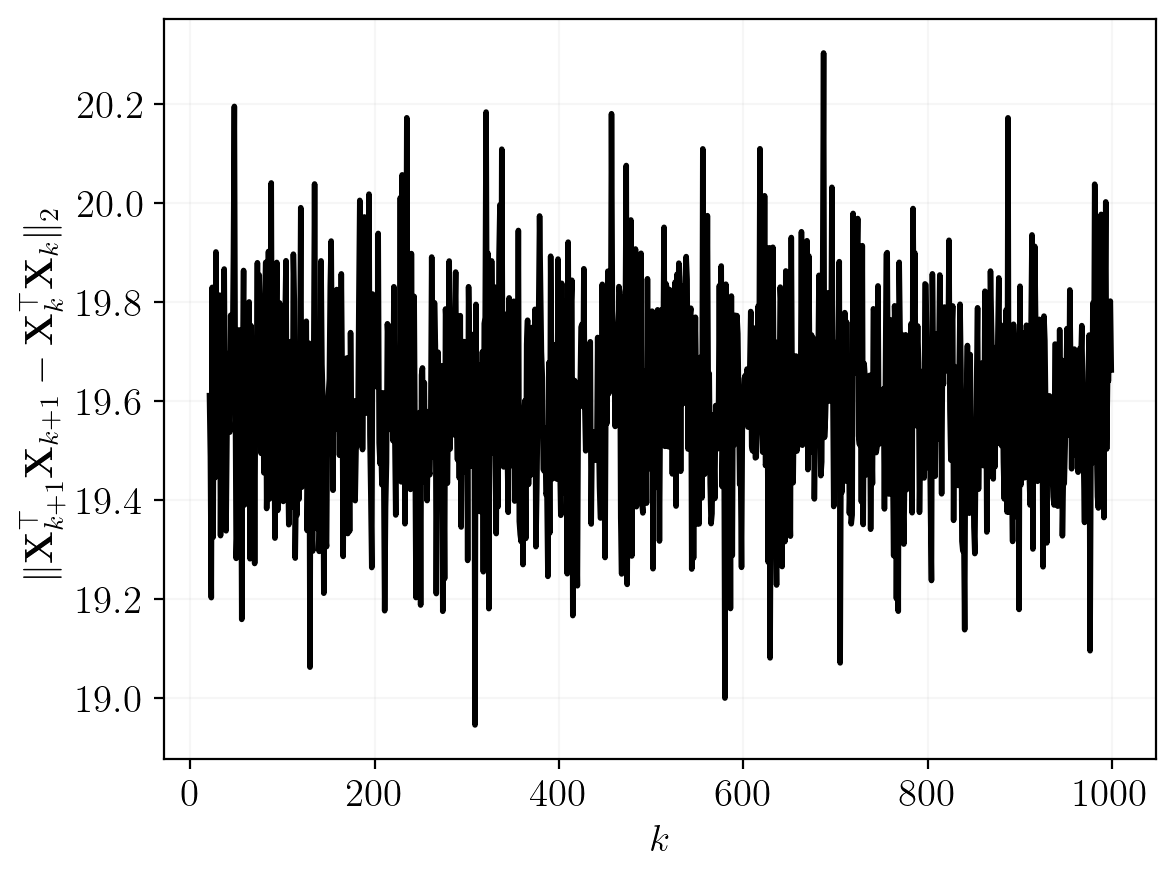

In [8]:
plt.plot(np.arange(n+1, m), norms)
plt.xlabel(r"$k$")
plt.ylabel(r"$\| \mathbf{X}_{k+1}^\top \mathbf{X}_{k+1} - \mathbf{X}_k^\top \mathbf{X}_k \|_2$")
plt.show()

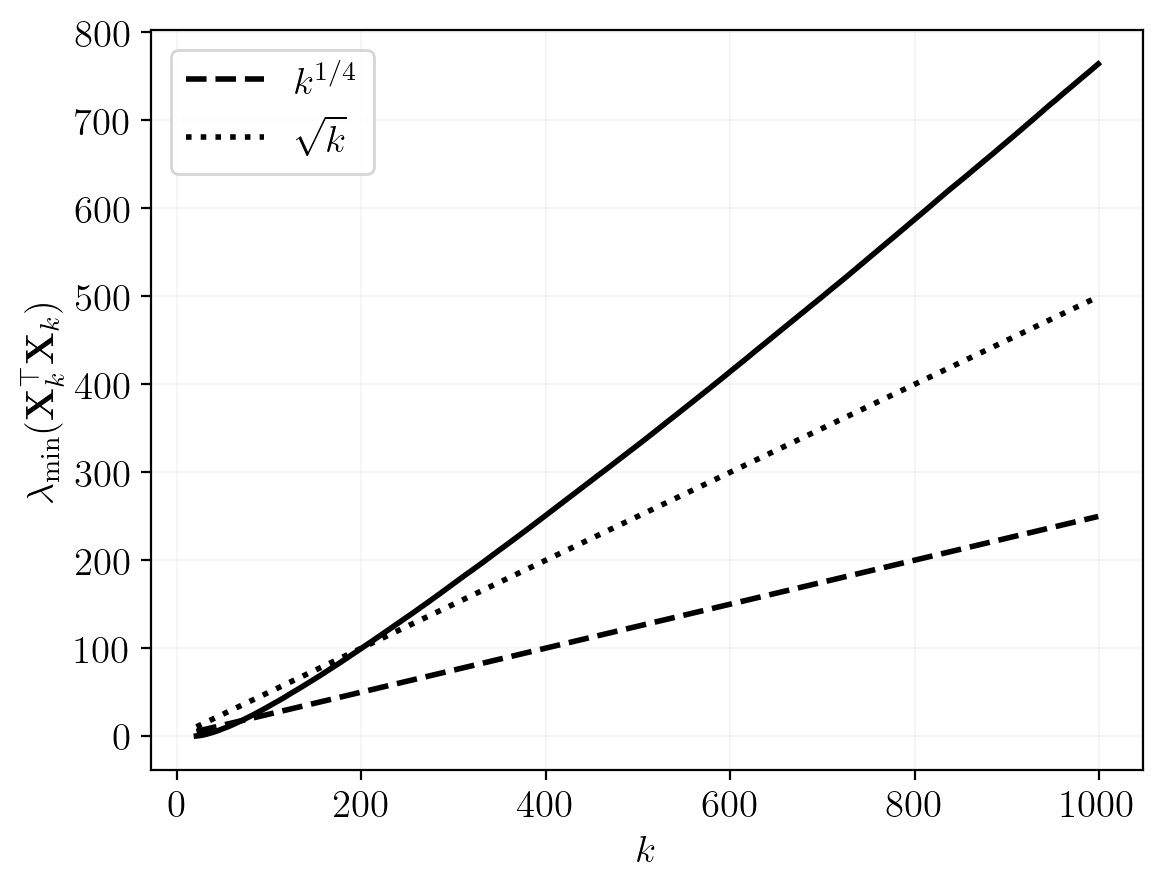

In [9]:
plt.plot(np.arange(n+1, m), eigvals)
plt.plot(np.arange(n+1, m), np.arange(n+1, m) ** 1/4, label=r"$k^{1/4}$")
plt.plot(np.arange(n+1, m), np.arange(n+1, m) ** 1/2, label=r"$\sqrt{k}$")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\lambda_{\min}(\mathbf{X}_k^\top \mathbf{X}_k)$")
plt.show()

In [10]:
def loglikelihood(y, X, w, sigma2):
    m = y.size
    return -m/2*np.log(2*np.pi*sigma2) - 1/(2*sigma2)*np.sum((y - X@w)**2)

#### Сходимость предложенных функций 

In [11]:
def D(means, variances):
    return variances

def M(means, variances):
    return np.abs(np.diff(means, n=1))

In [12]:
def posterior_parameters(m0, Sigma0, X, y, sigma2=1):
    Sigma = np.linalg.inv(np.linalg.inv(Sigma0) + 1/sigma2 * X.T @ X)
    m = Sigma @ (1/sigma2 * X.T @ y + np.linalg.inv(Sigma0) @ m0)
    return m, Sigma

In [13]:
def KL(mk, Sk, mkp1, Skp1):
    return 1/2 * (np.trace(np.linalg.inv(Skp1) @ Sk) + (mkp1 - mk) @ np.linalg.inv(Skp1) @ (mkp1 - mk) - mk.size + np.log(np.linalg.det(Skp1) / np.linalg.det(Sk)))

In [14]:
def s_score(mk, Sk, mkp1, Skp1):
    return np.exp(-1/2 * ((mkp1 - mk) @ np.linalg.inv(Sk + Skp1) @ (mkp1 - mk)))

In [15]:
B = 100
sample_sizes = np.arange(n+1, m)
means = []
variances = []

for k in tqdm(sample_sizes):
    tmp = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model = RegressionModel(X_k, y_k)
        w_hat = model.fit()
        tmp.append(loglikelihood(y, X, w_hat, sigma2))
    tmp = np.array(tmp)
    means.append(tmp.mean())
    variances.append(tmp.var())
    
means = np.array(means)
variances = np.array(variances)

  0%|          | 0/979 [00:00<?, ?it/s]

100%|██████████| 979/979 [00:36<00:00, 26.89it/s]


In [16]:
divergences = []
scores = []

m0 = np.zeros(n)
Sigma0 = alpha**(-1)*np.identity(n)

for _ in tqdm(range(B)):
    
    tmp_divergences = []
    tmp_scores = []
    k = m-1
    Xkp1, ykp1 = X, y
    mkp1, Skp1 = posterior_parameters(m0, Sigma0, Xkp1, ykp1)

    while k >= sample_sizes[0]:
        index = np.random.randint(k)
        Xk, yk = np.delete(Xkp1, index, axis=0), np.delete(ykp1, index, axis=0)
        mk, Sk = posterior_parameters(m0, Sigma0, Xk, yk)
        tmp_divergences.append(KL(mk, Sk, mkp1, Skp1))
        tmp_scores.append(s_score(mk, Sk, mkp1, Skp1))
        Xkp1, ykp1 = Xk, yk
        mkp1, Skp1 = mk, Sk
        k -= 1
        
    divergences.append(tmp_divergences)
    scores.append(tmp_scores)
    
divergences = np.mean(divergences, axis=0)
scores = np.mean(scores, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


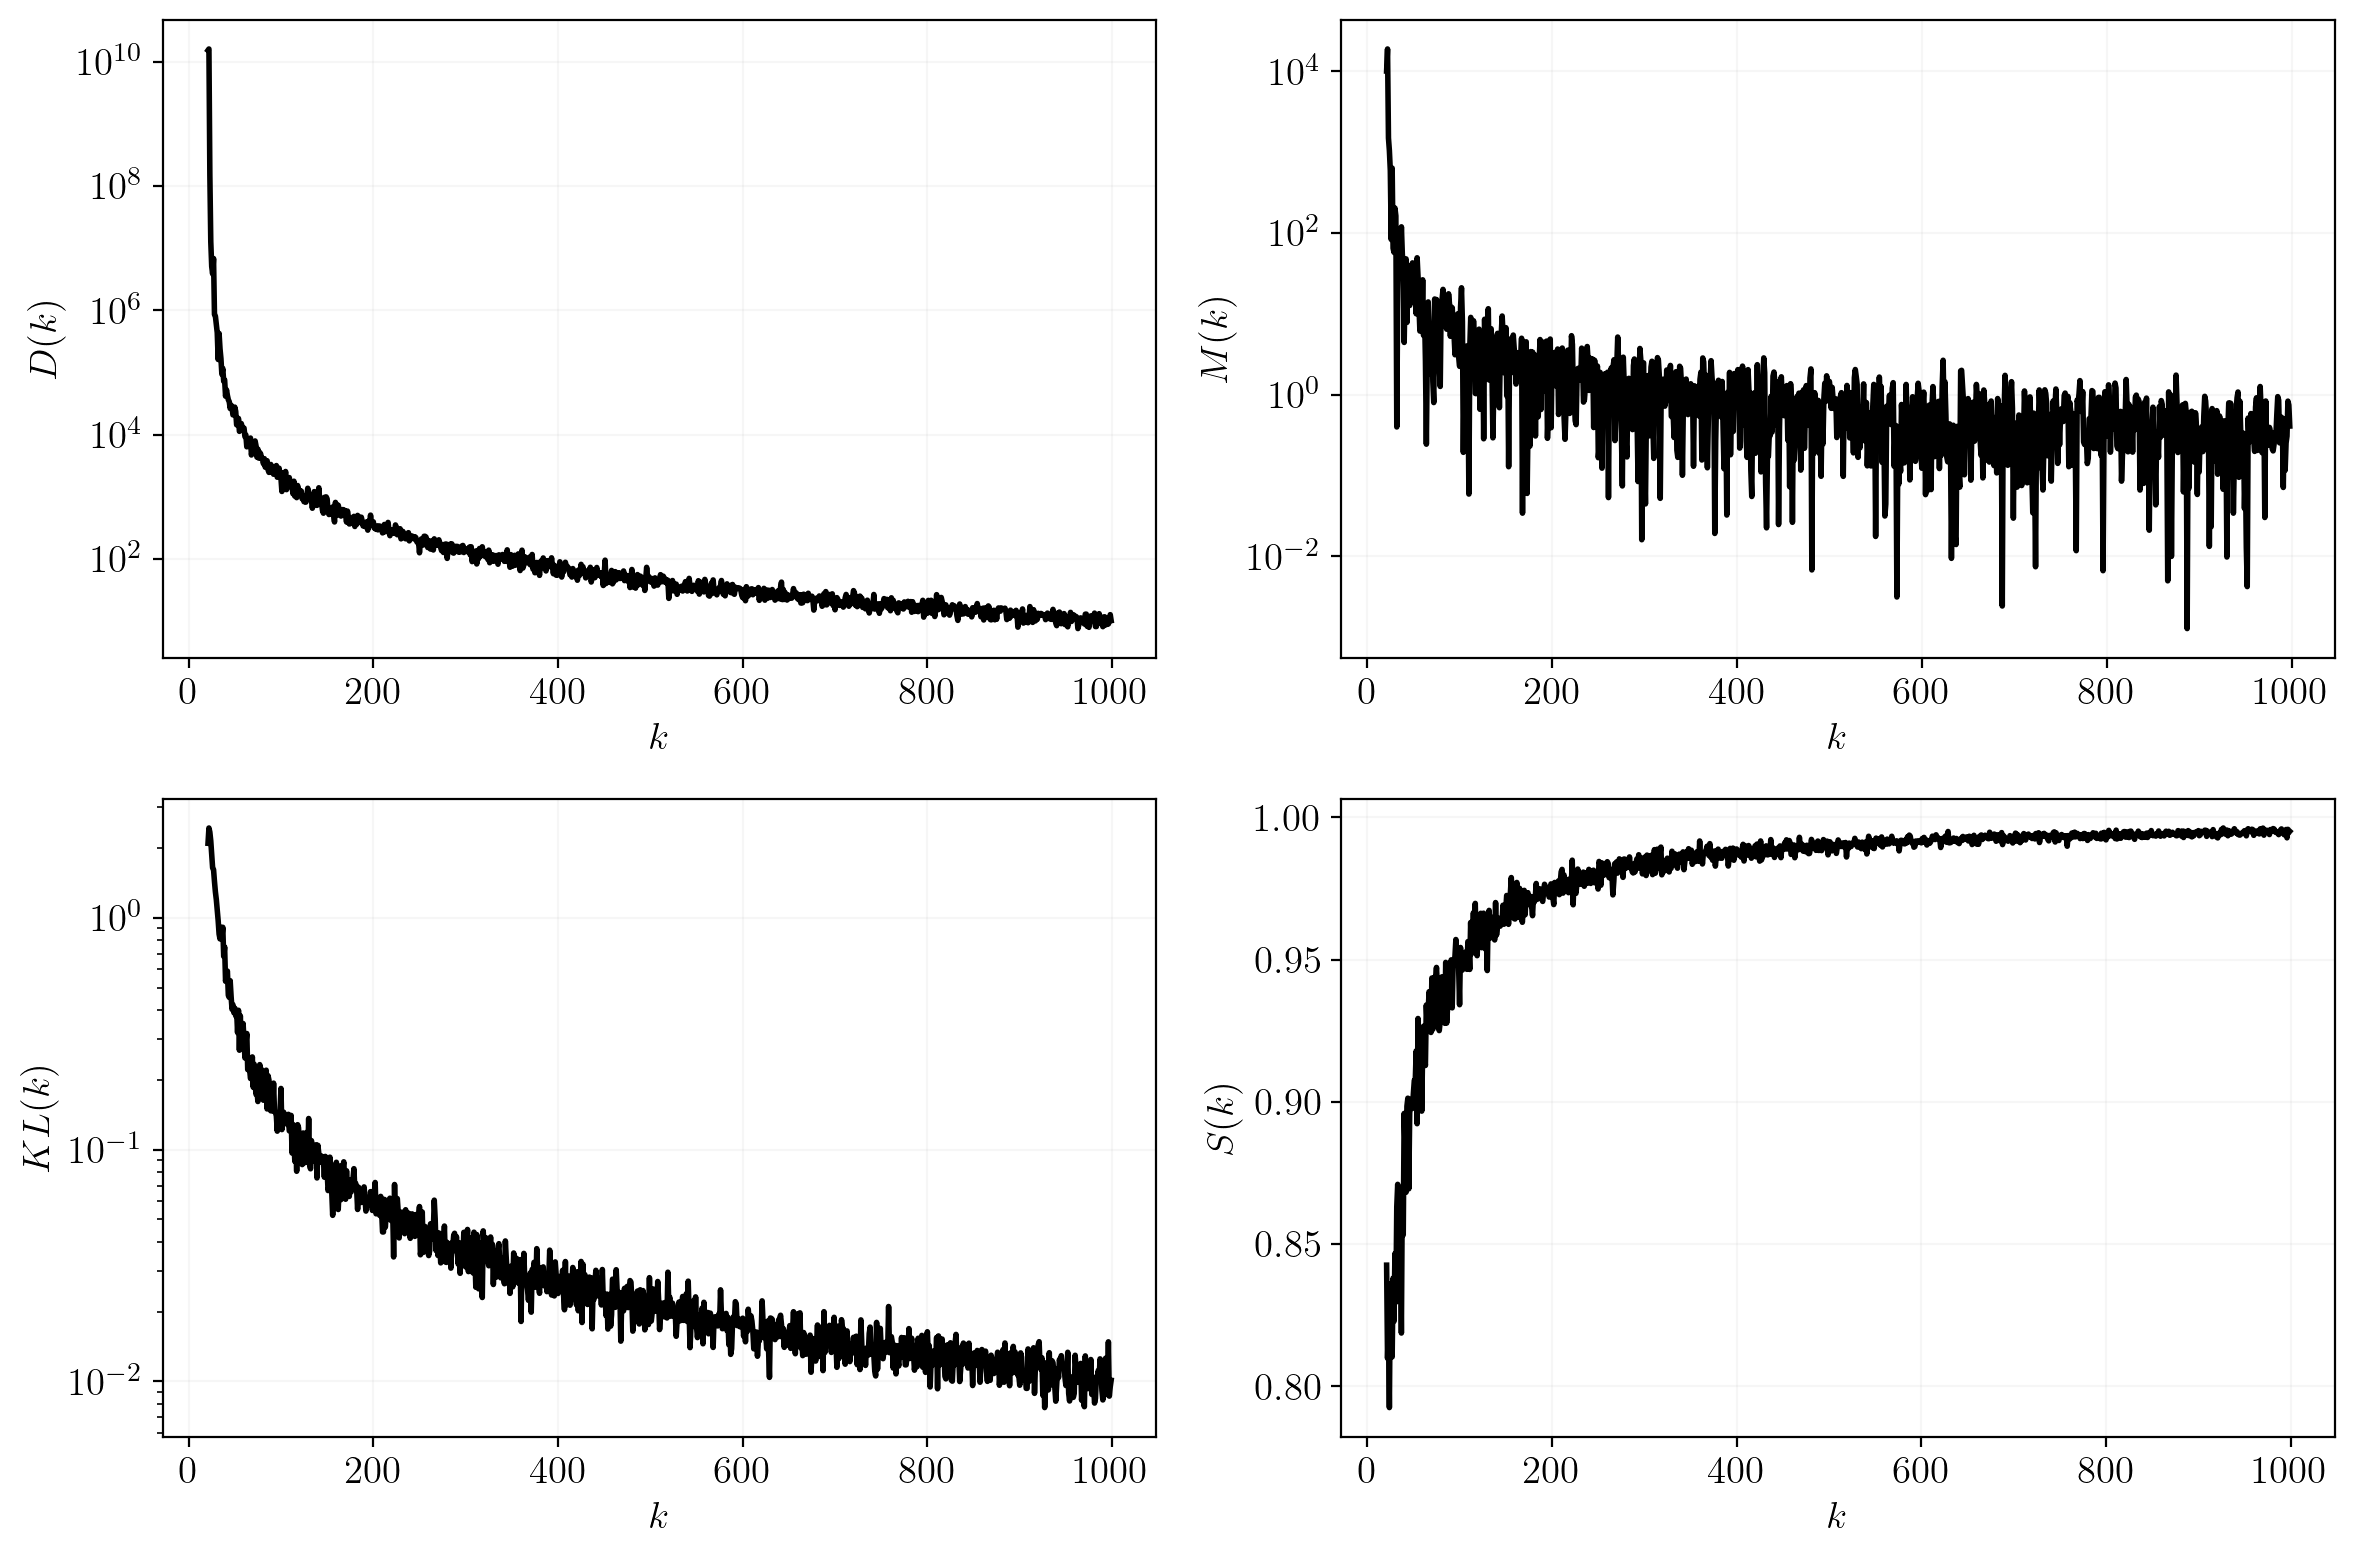

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0][0].plot(sample_sizes, D(means, variances))
ax[0][0].set_yscale("log")
ax[0][0].set_ylabel(r"$D(k)$")
ax[0][0].set_xlabel(r"$k$")

ax[0][1].plot(sample_sizes[:-1], M(means, variances))
ax[0][1].set_yscale("log")
ax[0][1].set_ylabel(r"$M(k)$")
ax[0][1].set_xlabel(r"$k$")

ax[1][0].plot(sample_sizes, divergences[::-1])
ax[1][0].set_yscale("log")
ax[1][0].set_ylabel(r"$KL(k)$")
ax[1][0].set_xlabel(r"$k$")

ax[1][1].plot(sample_sizes, scores[::-1])
#ax[1][1].set_yscale('log')
ax[1][1].set_ylabel(r"$S(k)$")
ax[1][1].set_xlabel(r"$k$")

plt.tight_layout()
plt.savefig(figures_path+"synthetic-regression-functions", format=format, bbox_inches="tight")
plt.show()

#### Определение достаточного размера выборки

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [18]:
B = 1000
sample_sizes = np.linspace(2*n, X.shape[0], 100, dtype=int)
means = []
variances = []

for k in tqdm(sample_sizes):
    tmp = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model = RegressionModel(X_k, y_k)
        w_hat = model.fit()
        tmp.append(loglikelihood(y, X, w_hat, sigma2))
    tmp = np.array(tmp)
    means.append(tmp.mean())
    variances.append(tmp.var())

means = np.array(means)
variances = np.array(variances)

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


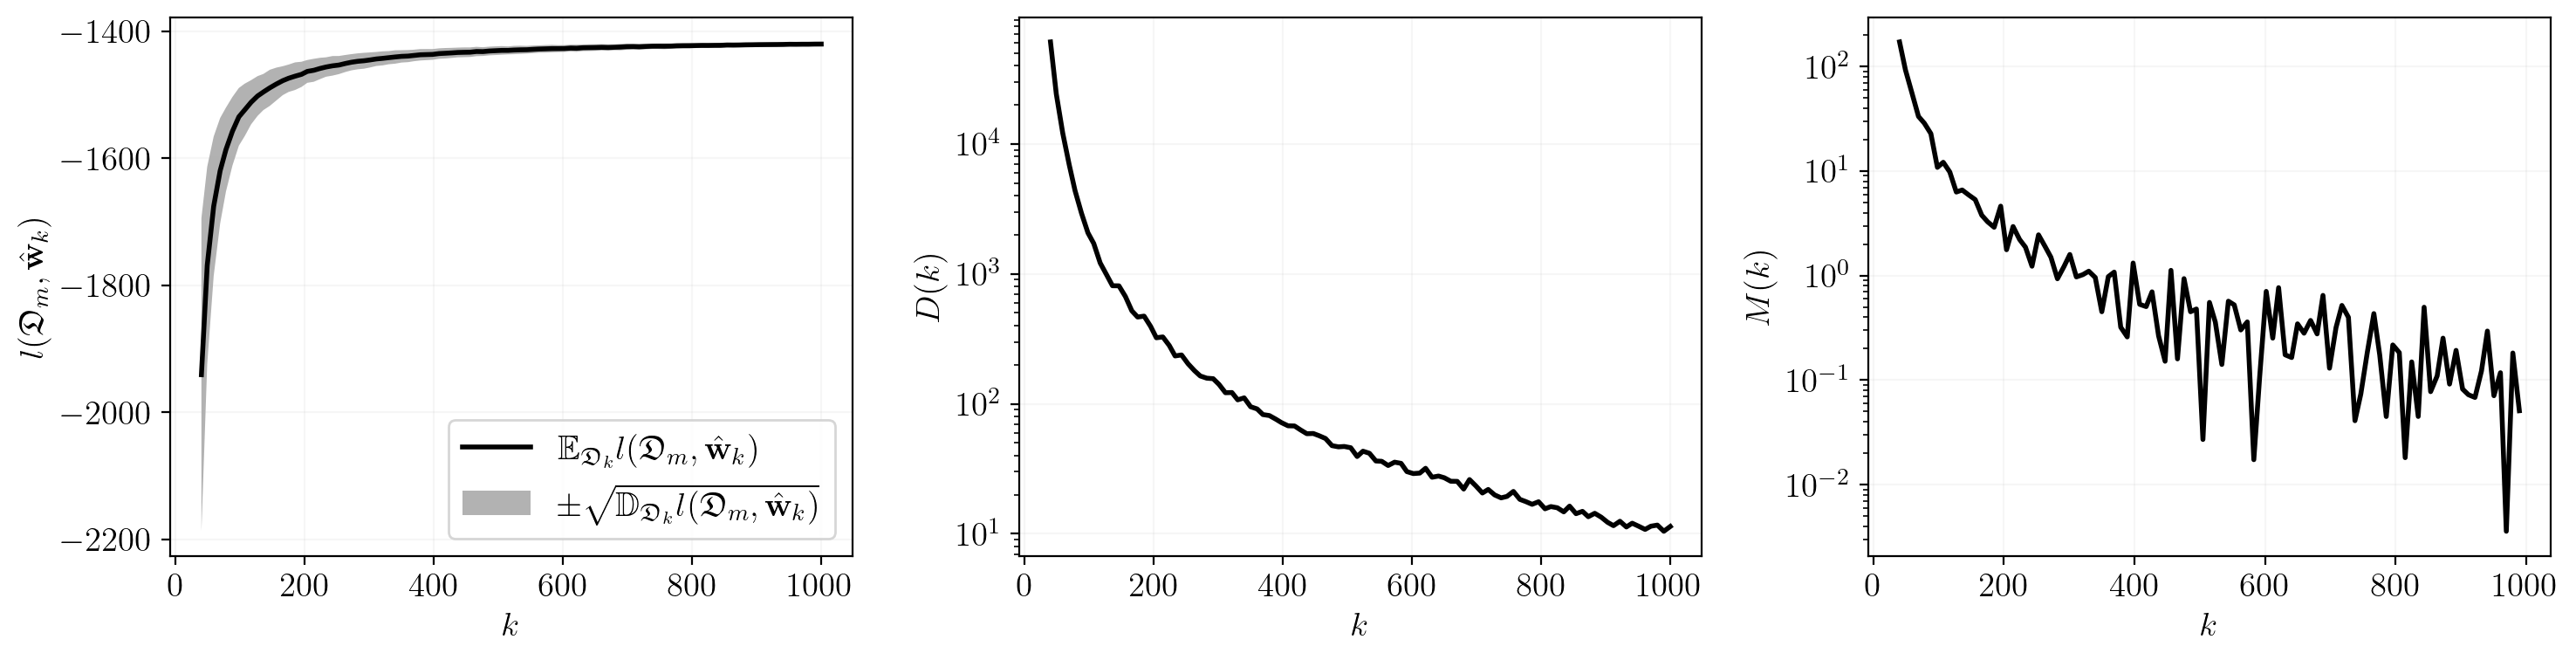

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        
stds = np.sqrt(variances)

ax1.plot(sample_sizes, means, label=r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
ax1.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r"$\pm \sqrt{\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)}$")
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
ax1.legend(loc="lower right")

ax2.plot(sample_sizes, D(means, variances))
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$D(k)$")
ax2.set_yscale('log')

ax3.plot(sample_sizes[:-1], M(means, variances))
ax3.set_xlabel(r"$k$")
ax3.set_ylabel(r"$M(k)$")
ax3.set_yscale('log')

fig.tight_layout()
plt.show()

In [20]:
visualizer = Visualizer(sample_sizes, means, variances, loss=False, format=format)
estimator = Estimator(sample_sizes, means, variances)

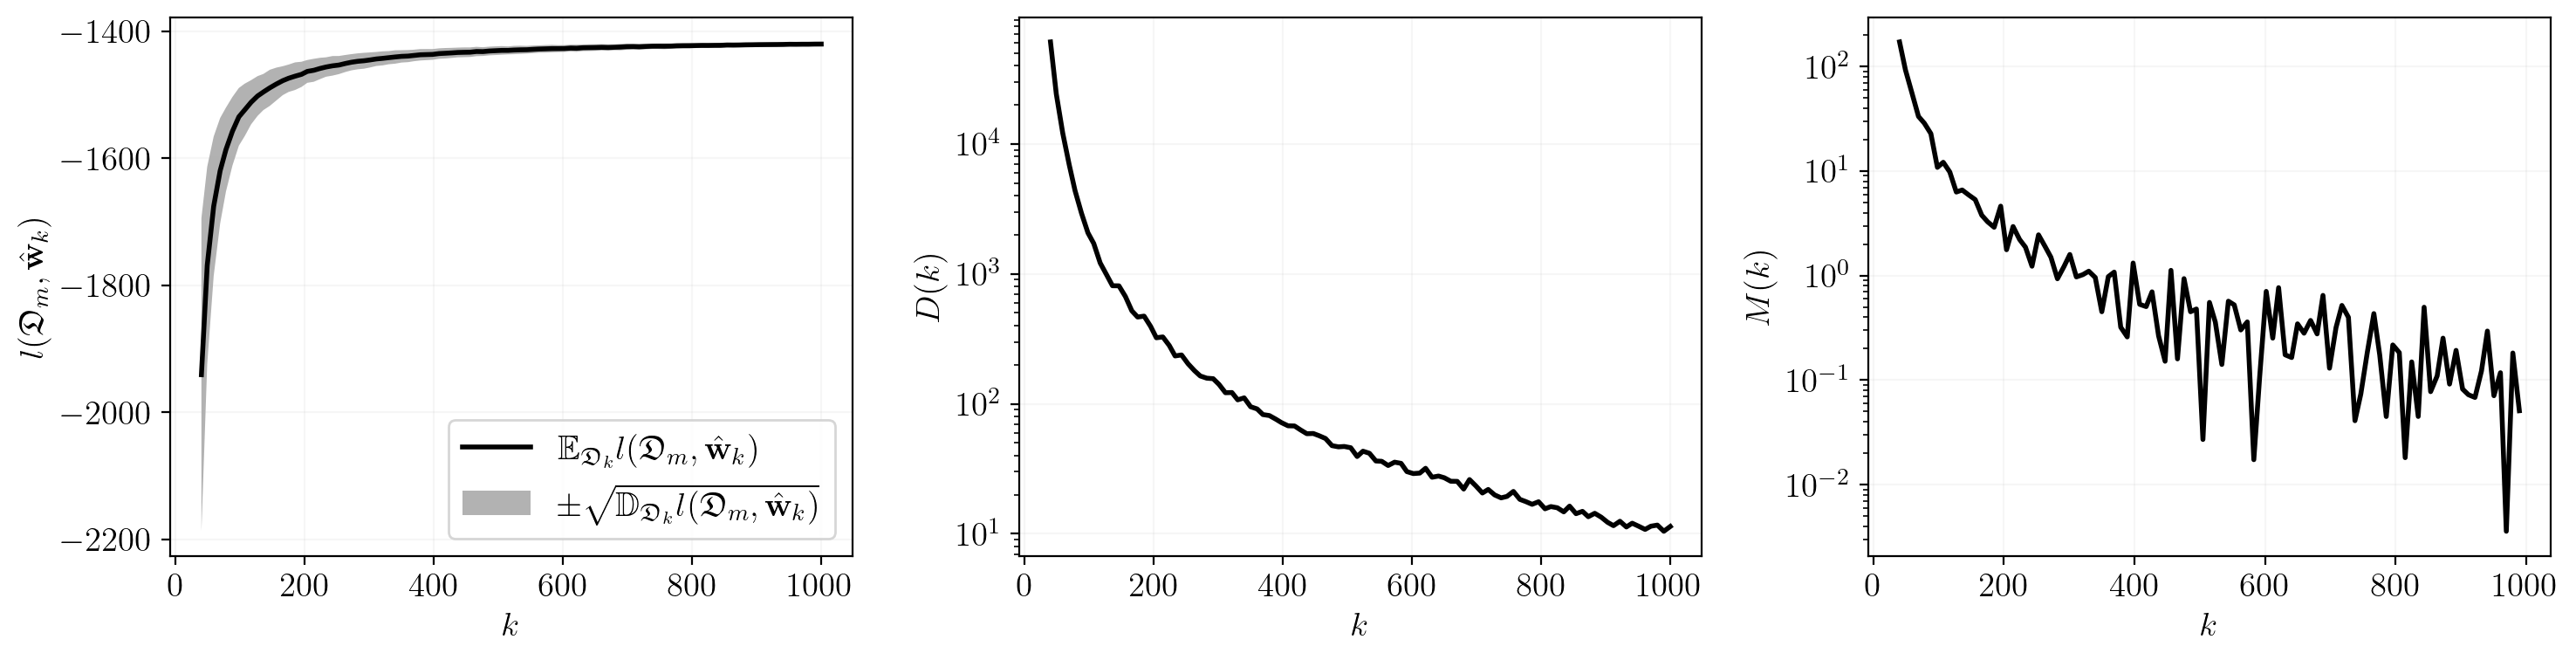

In [21]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [22]:
estimator = Estimator(sample_sizes, means, variances)
estimator.sufficient_sample_size(eps=3e1, method="variance")
estimator.sufficient_sample_size(eps=4e-1, method="rate")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


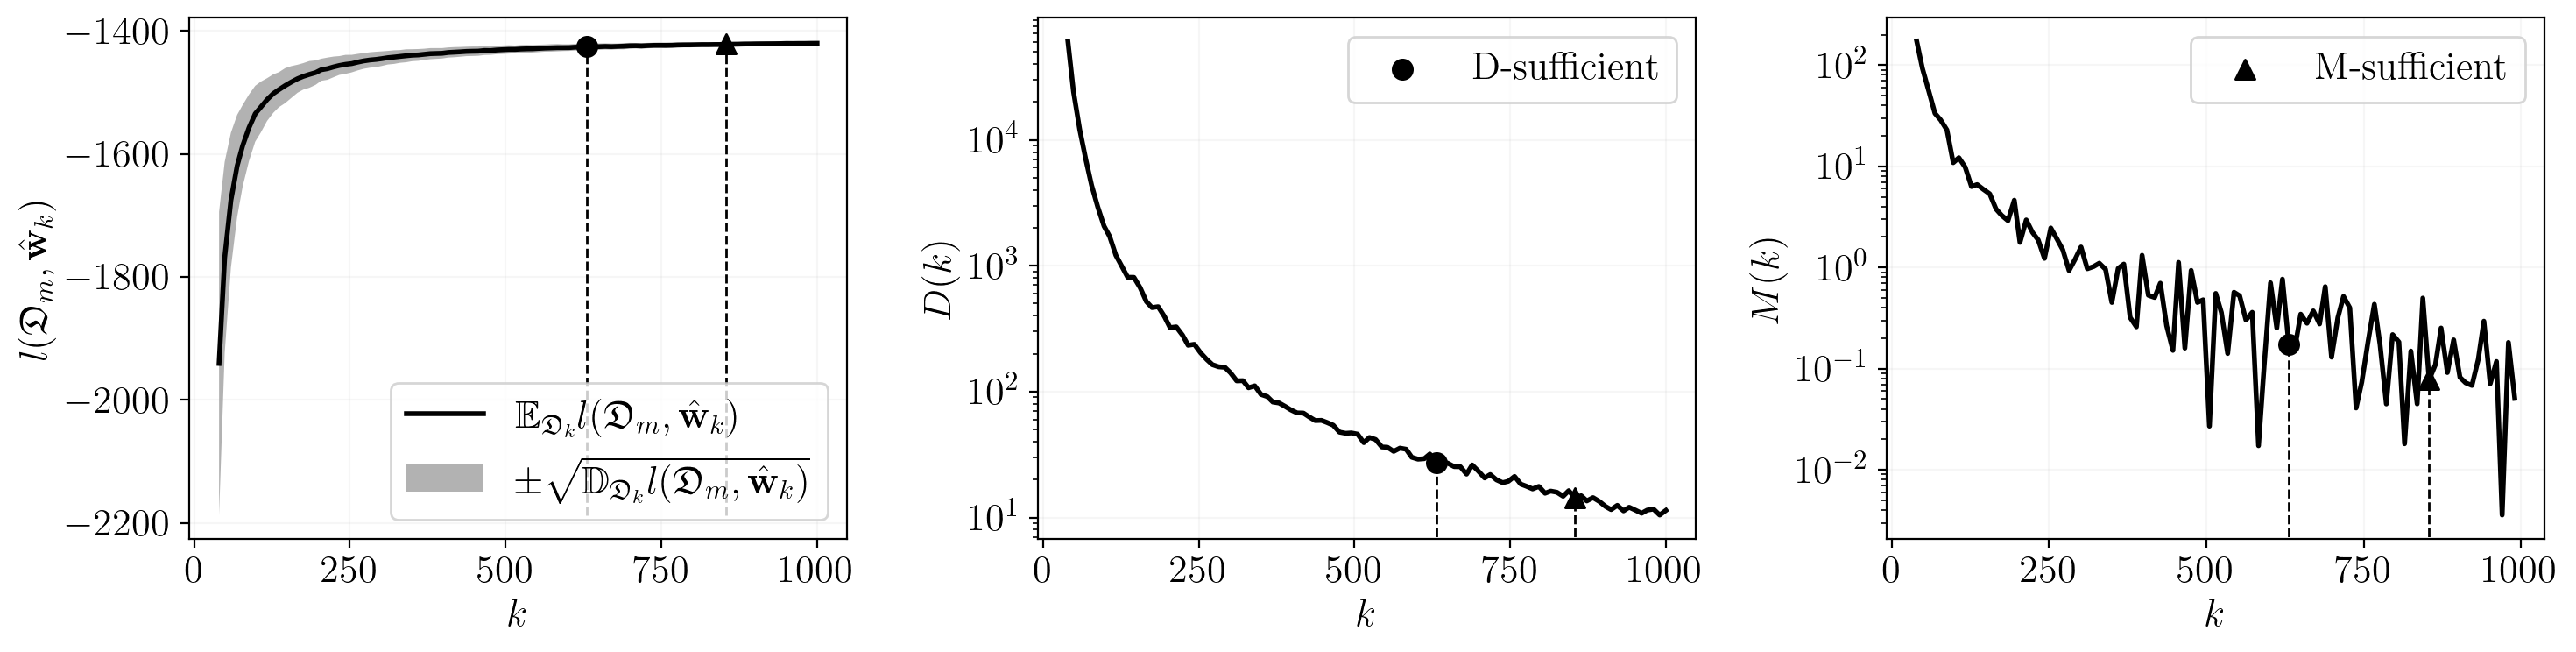

In [40]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"synthetic-regression-sufficient")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [41]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx(train_size=0.7)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


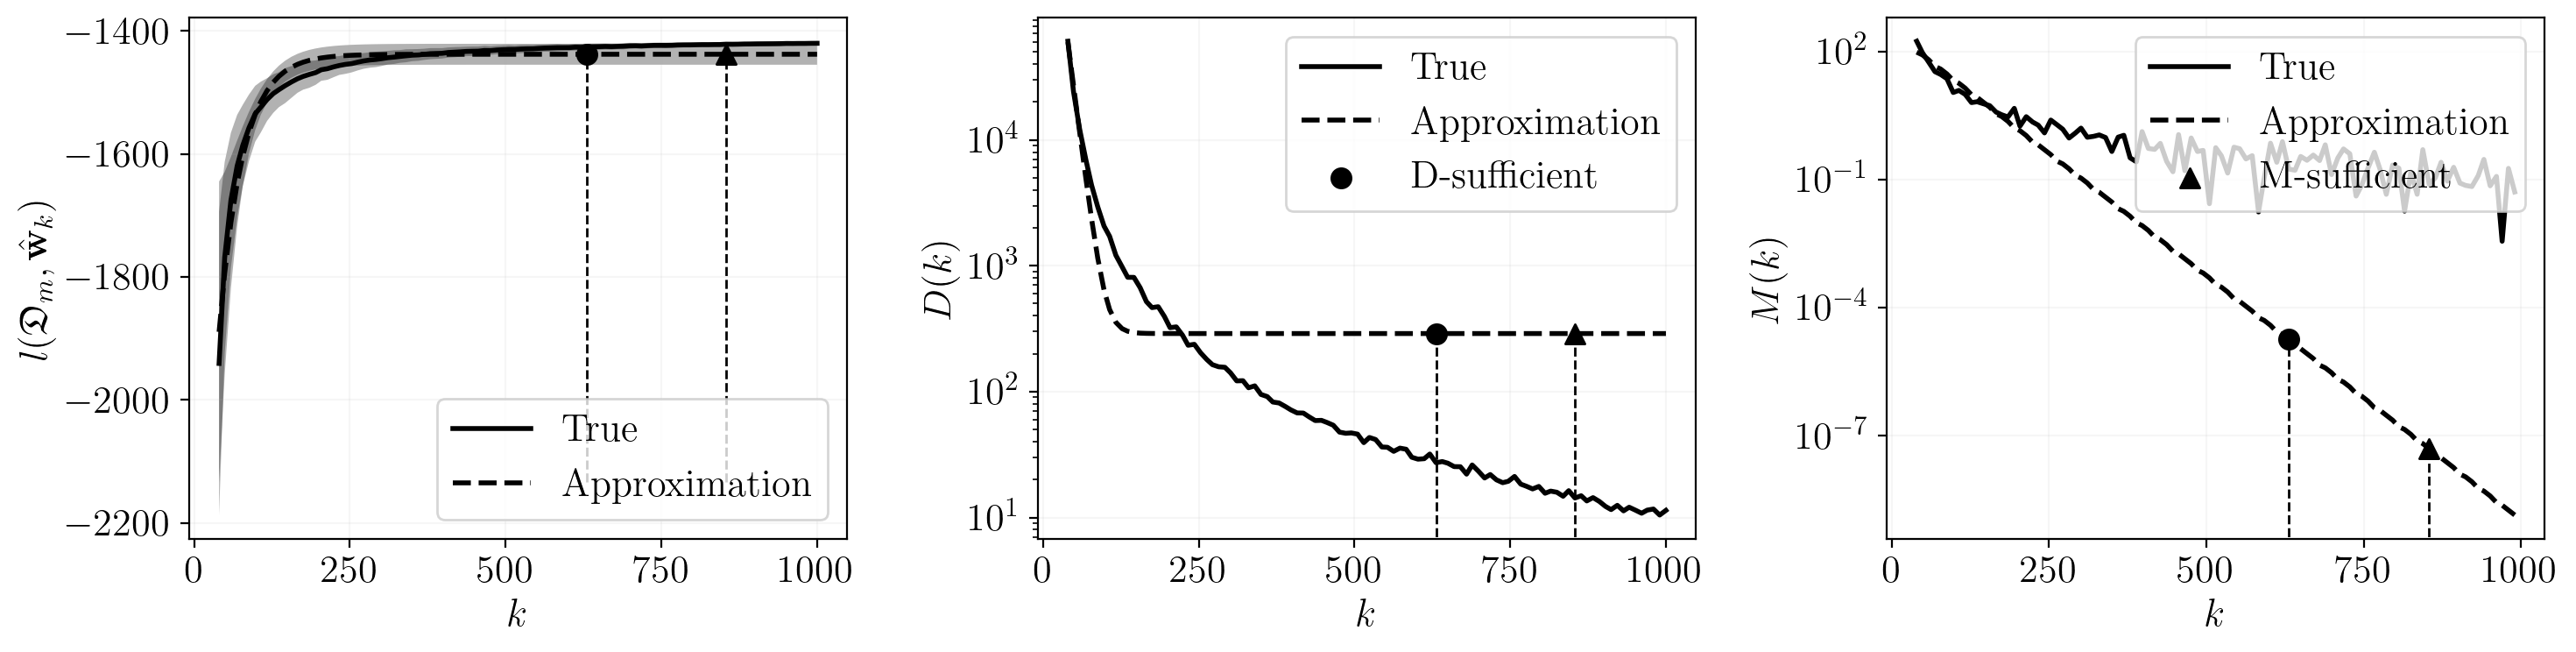

In [42]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"synthetic-regression-approximation")

# Логистическая регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \sigma(y_i \mathbf{w}^\top \mathbf{x}_i) $$

Сгенерируем синтетическую выборку

In [43]:
def sigmoid(x):
    x = np.asarray(x)
    return 1 / (1 + np.exp(-x))

In [44]:
def likelihood(y, X, w):
    return np.prod(sigmoid(y * (X @ w)))

In [45]:
def loglikelihood(y, X, w):
    return np.sum(np.log(sigmoid(y * (X @ w))))

In [46]:
m = 1000
n = 20

mu = np.zeros(n)
Sigma = np.identity(n)

alpha = 1

In [47]:
X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
y = sps.bernoulli(p=sigmoid(X @ w)).rvs(size=m)
y[y == 0] = -1

In [48]:
dataset = Dataset(X, y)

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [49]:
B = 1000
sample_sizes = np.linspace(2*n, X.shape[0], 50, dtype=int)
means = []
variances = []

for k in tqdm(sample_sizes):
    tmp = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model = LogisticModel(X_k, y_k, alpha=alpha)
        w_hat = model.fit()
        tmp.append(loglikelihood(y, X, w_hat))
    tmp = np.array(tmp)
    means.append(tmp.mean())
    variances.append(tmp.var())

means = np.array(means)
variances = np.array(variances)

100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


In [50]:
visualizer = Visualizer(sample_sizes, means, variances, loss=False, format=format)
estimator = Estimator(sample_sizes, means, variances)

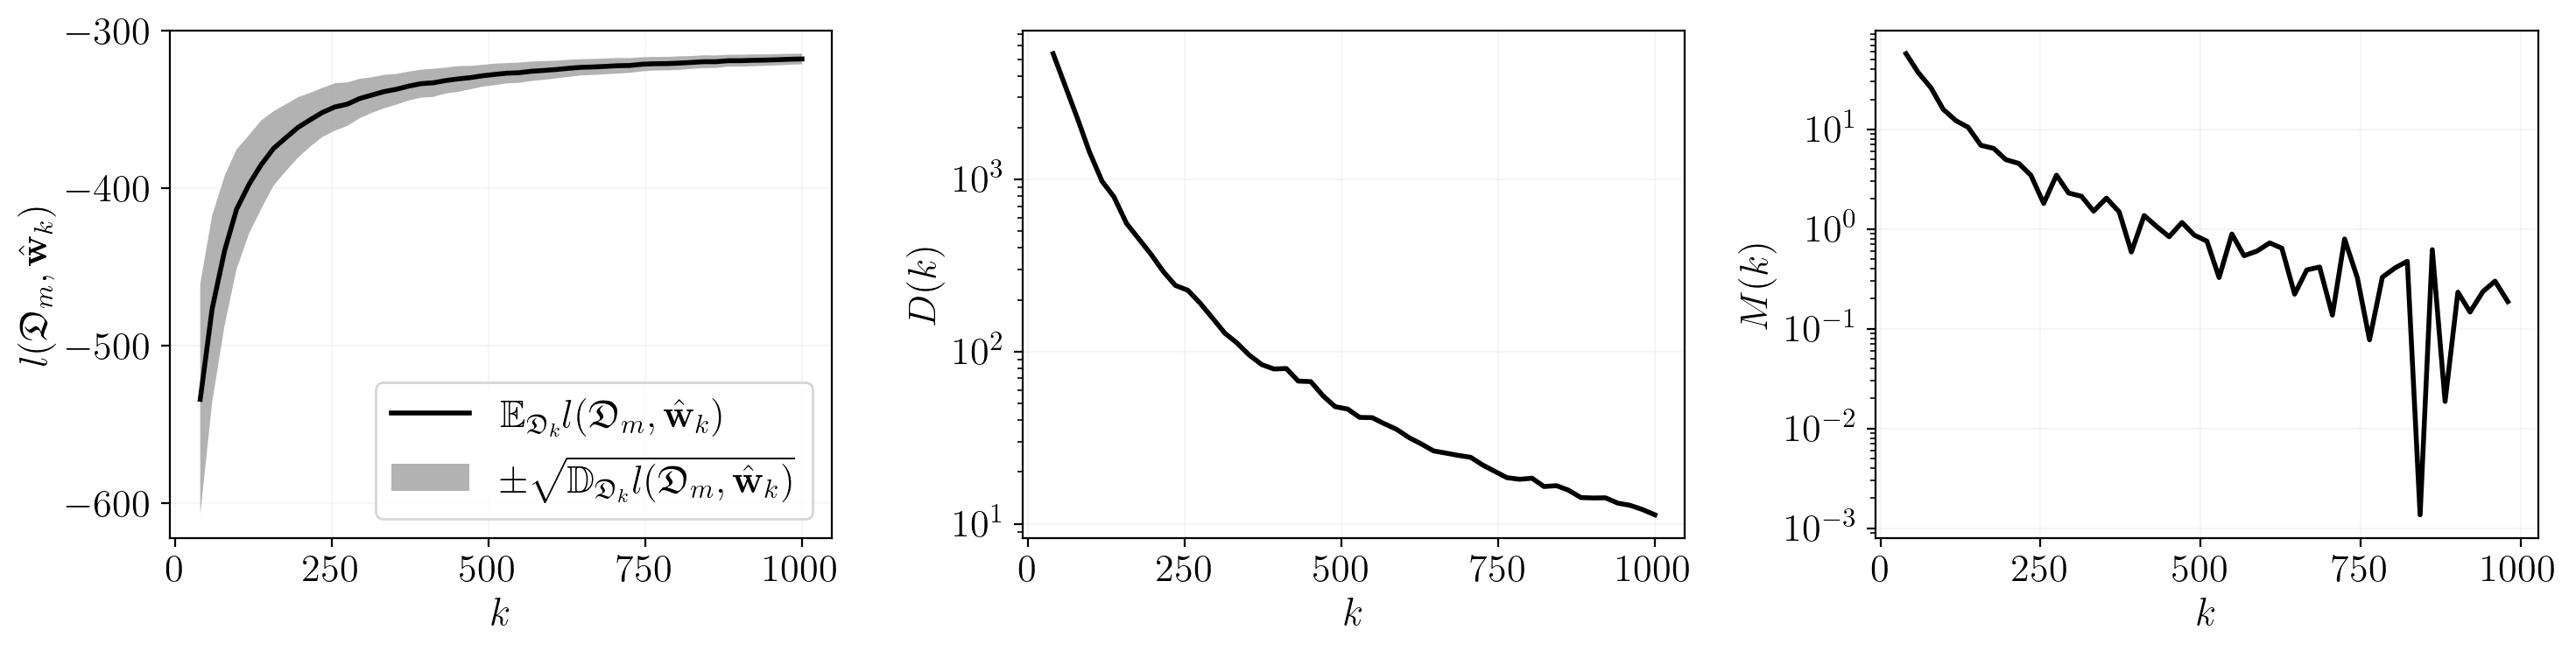

In [51]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [52]:
estimator = Estimator(sample_sizes, means, variances)
estimator.sufficient_sample_size(eps=3e1, method="variance")
estimator.sufficient_sample_size(eps=6e-1, method="rate")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


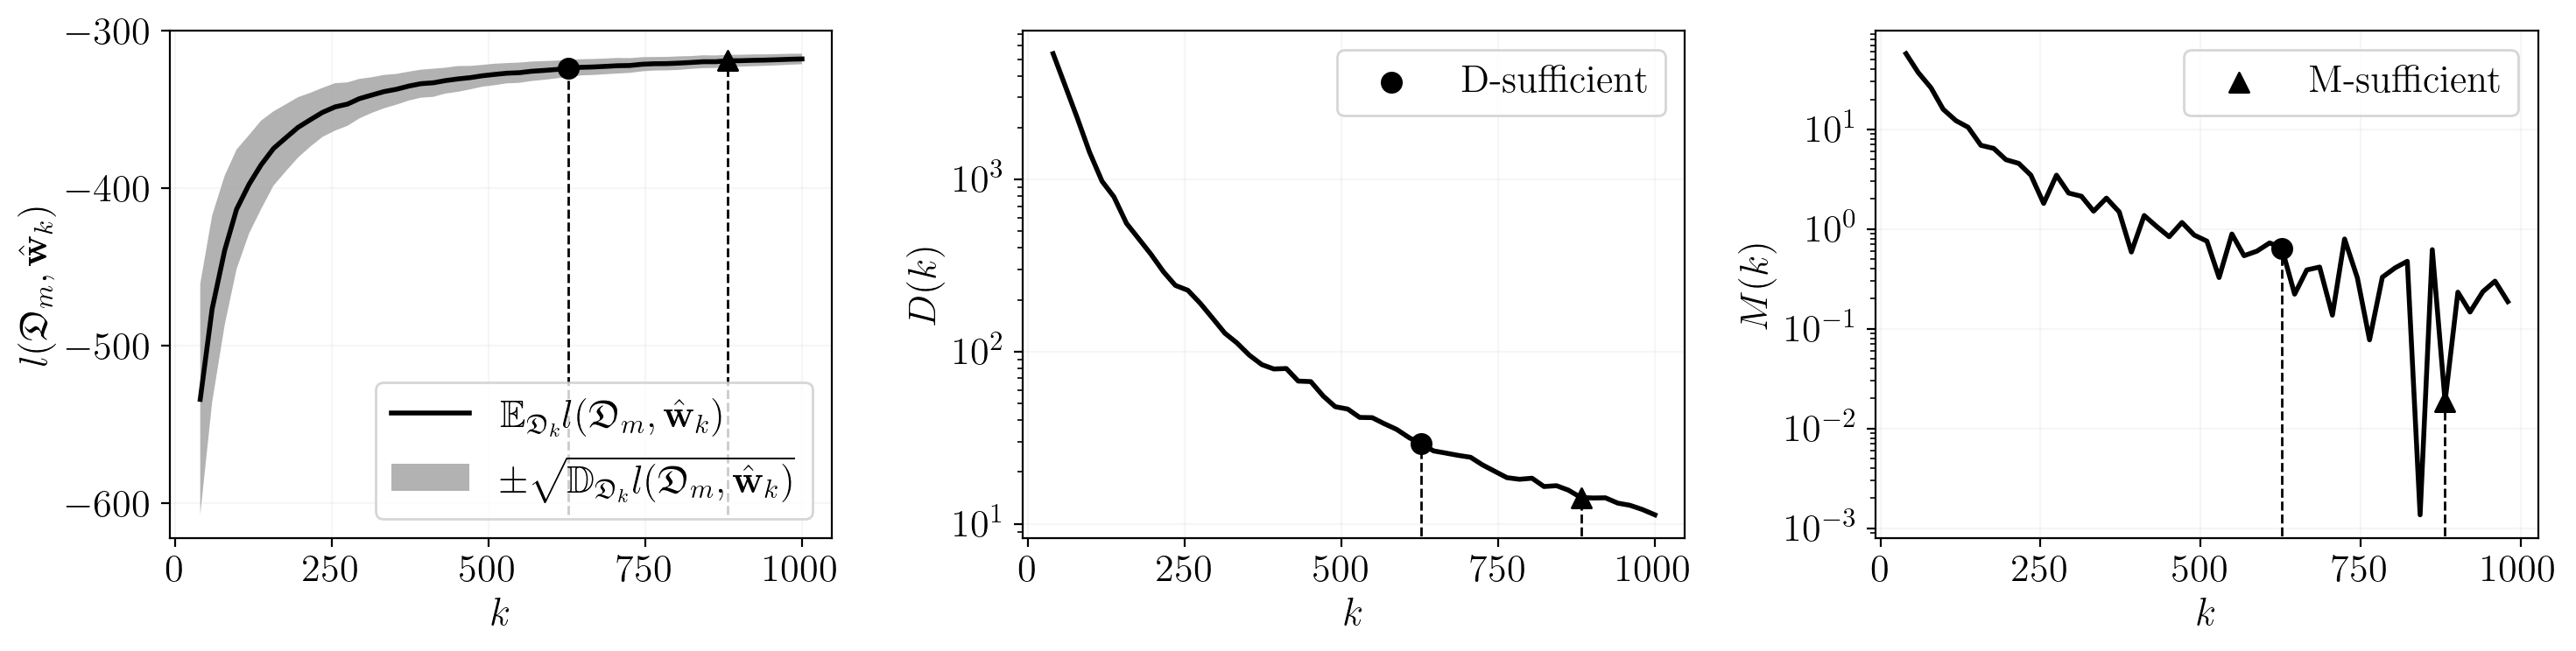

In [53]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"synthetic-classification-sufficient")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [54]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx(train_size=0.6)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


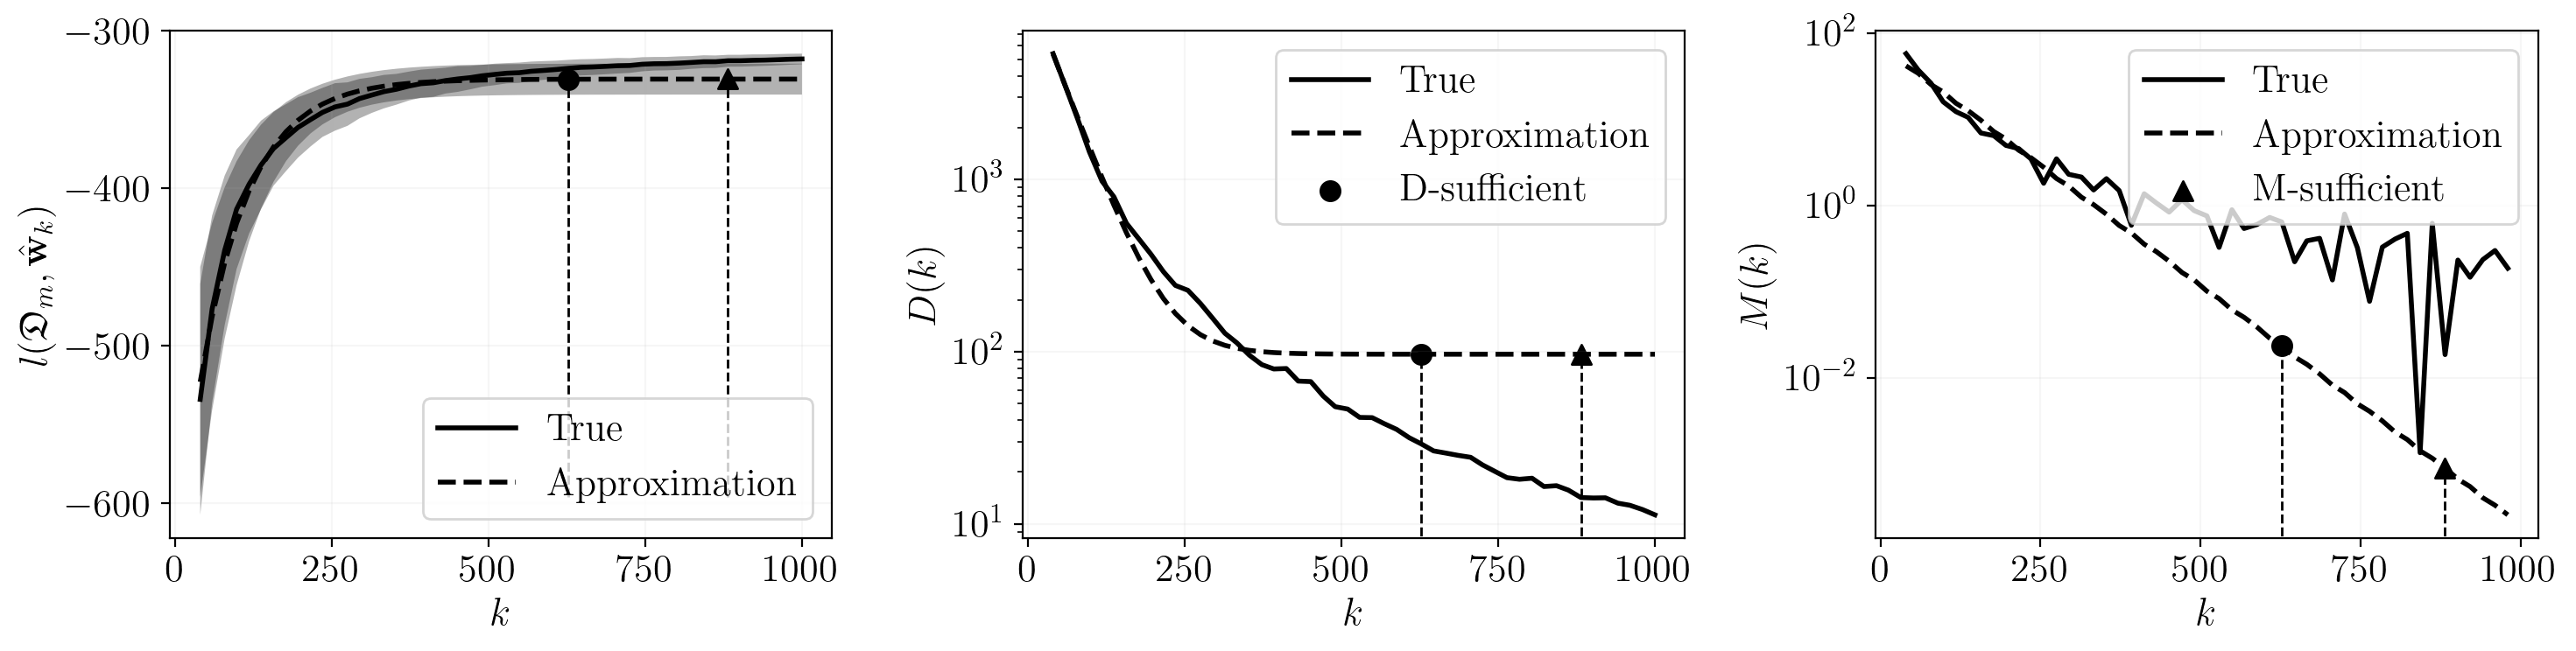

In [55]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"synthetic-classification-approximation")

# Датасет с задачей регрессии

In [56]:
import os
import pickle

def save_object(obj, filename):
    # Overwrites any existing file.
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def load_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
        return obj

In [57]:
results_regression = load_object("plots/datasets_regression.pkl")
results_regression.keys()

dict_keys(['Abalone', 'Auto MPG', 'Liver Disorders', 'Wine Quality', 'Parkinsons Telemonitoring', 'Bike Sharing Dataset', 'Real estate valuation', 'Heart failure clinical records'])

In [58]:
sample_sizes = results_regression['Abalone']['sample_sizes']
means = results_regression['Abalone']['mean']
stds = results_regression['Abalone']['std']

In [59]:
means *= -1
variances = stds ** 2

In [60]:
visualizer = Visualizer(sample_sizes, means, variances, loss=True, format=format)
estimator = Estimator(sample_sizes, means, variances)

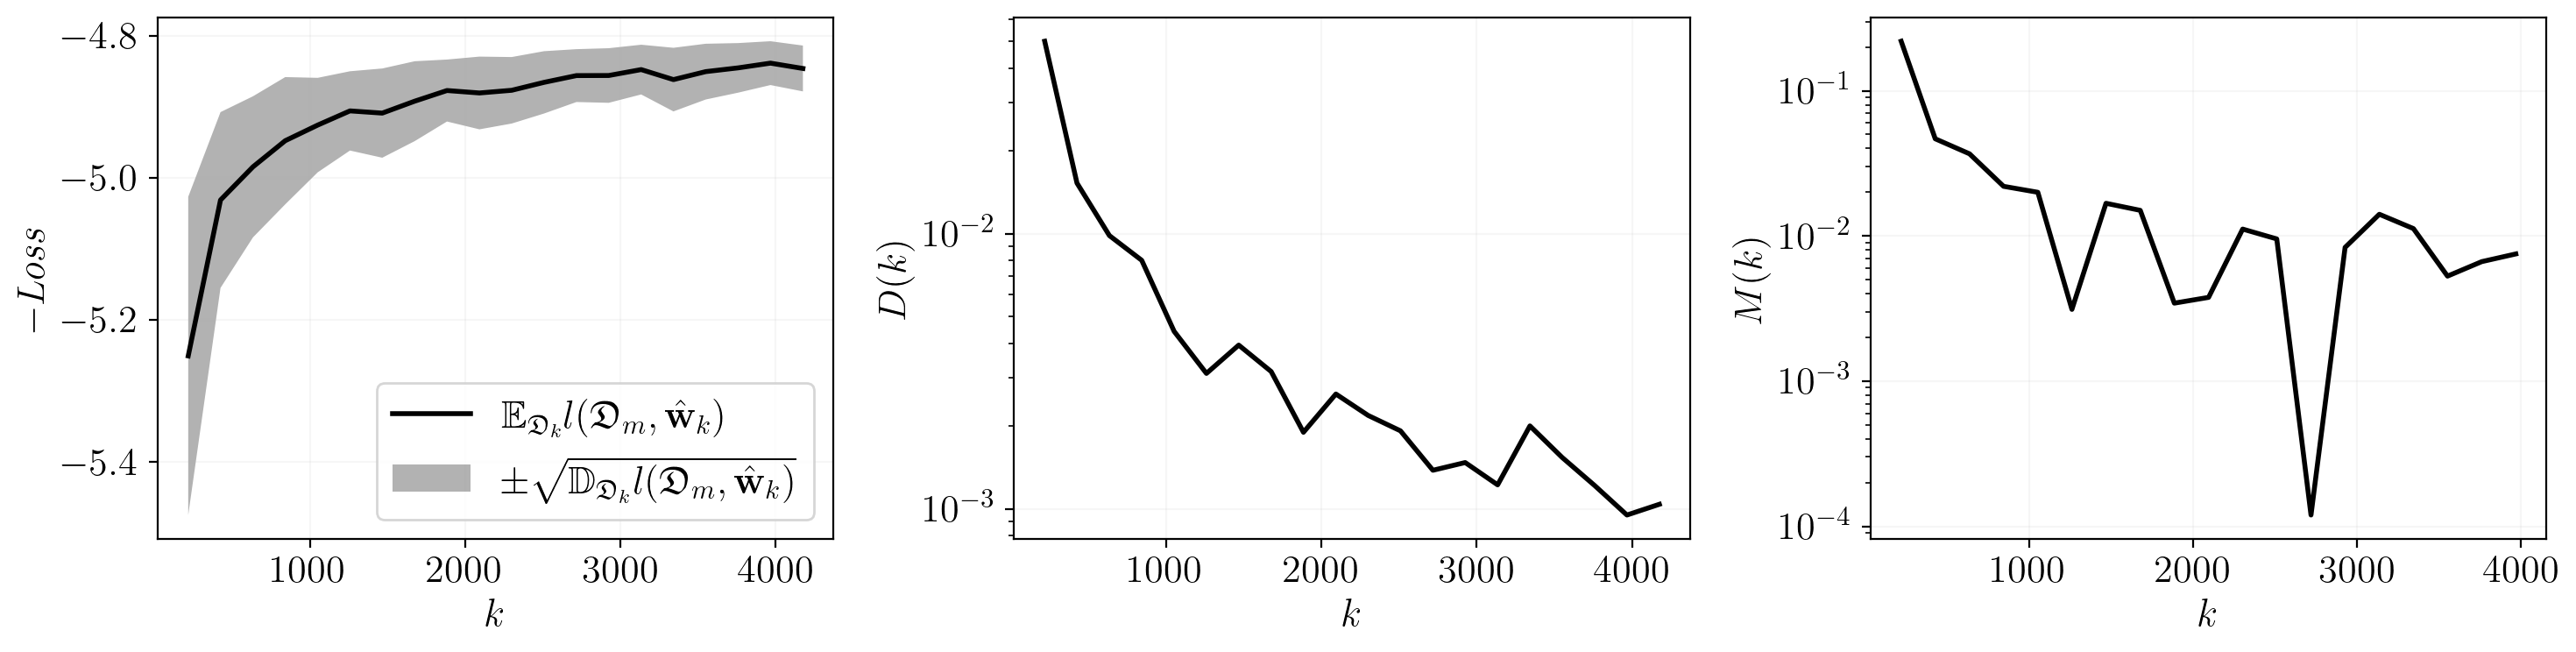

In [61]:
visualizer.plot_bootstrap()

#### Достаточный размер выборки не превосходит доступный

In [62]:
estimator = Estimator(sample_sizes, means, variances)
estimator.sufficient_sample_size(eps=2.5e-3, method="variance")
estimator.sufficient_sample_size(eps=8e-3, method="rate")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


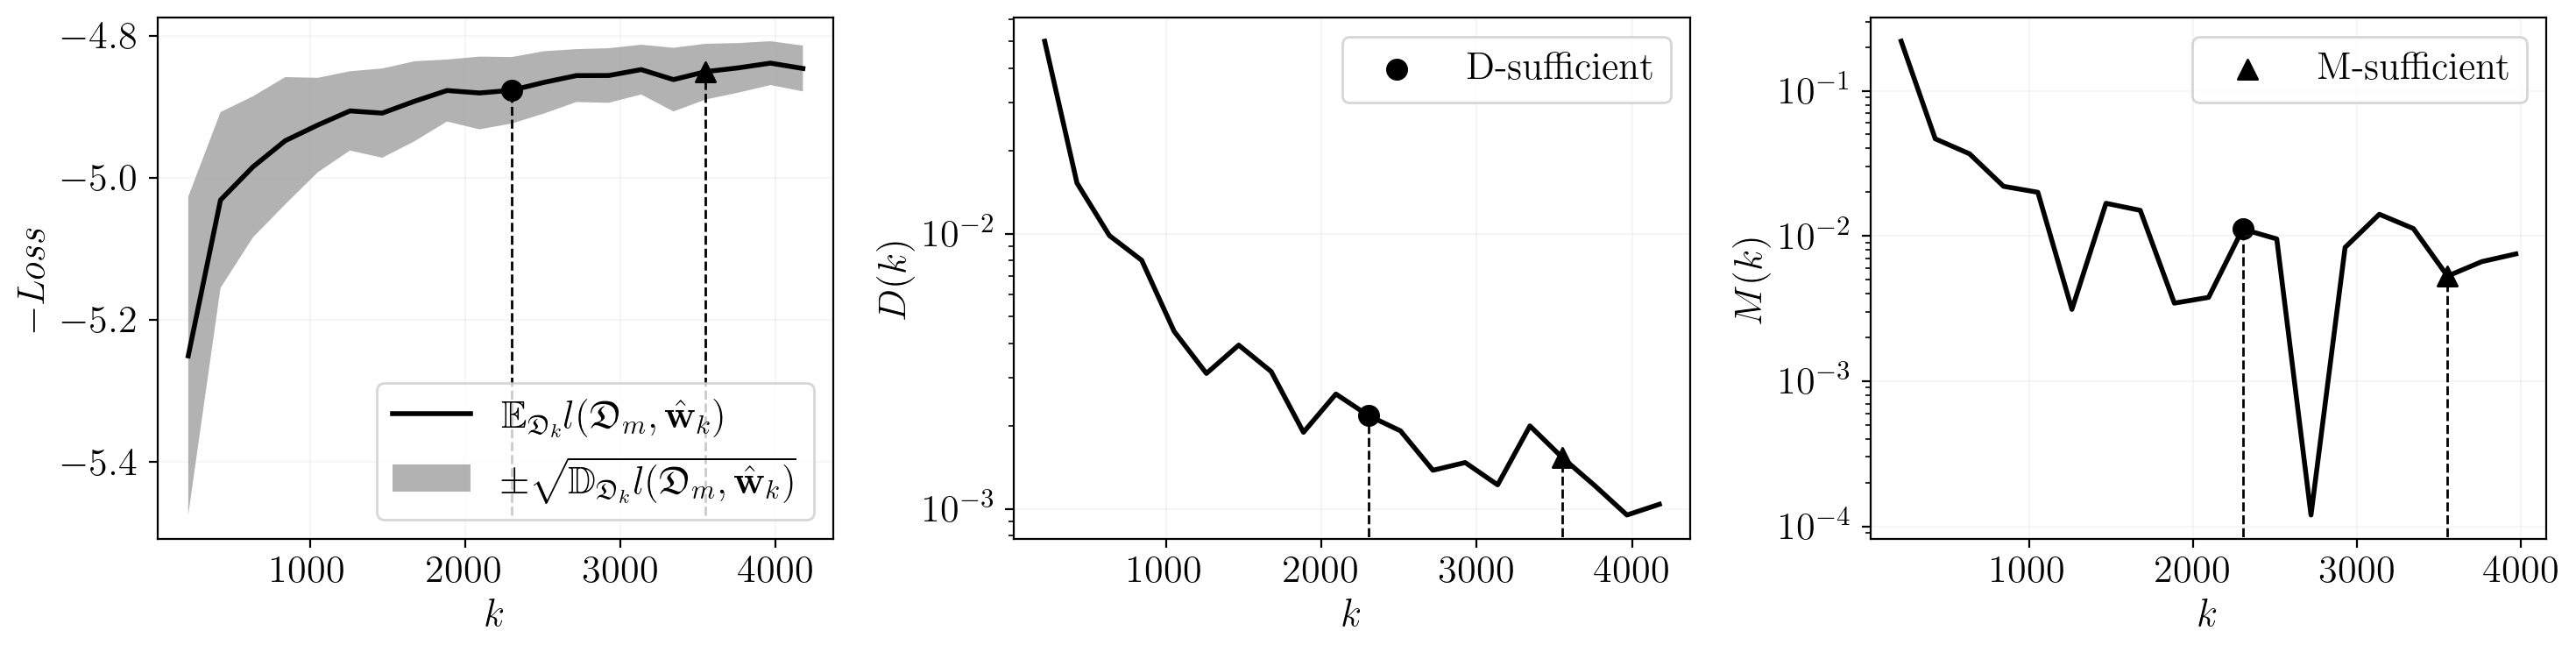

In [63]:
visualizer.plot_bootstrap_sufficient(estimator, save=True, filename=figures_path+"abalone-sufficient")

#### Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

2. Аппроксимация дисперсии

$$ \mathrm{variance}(k) \approx w_0 + w_1 \cdot \exp(w_2 \cdot k) $$

In [64]:
forecaster = Forecaster(sample_sizes, means, variances)
forecaster.approx()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


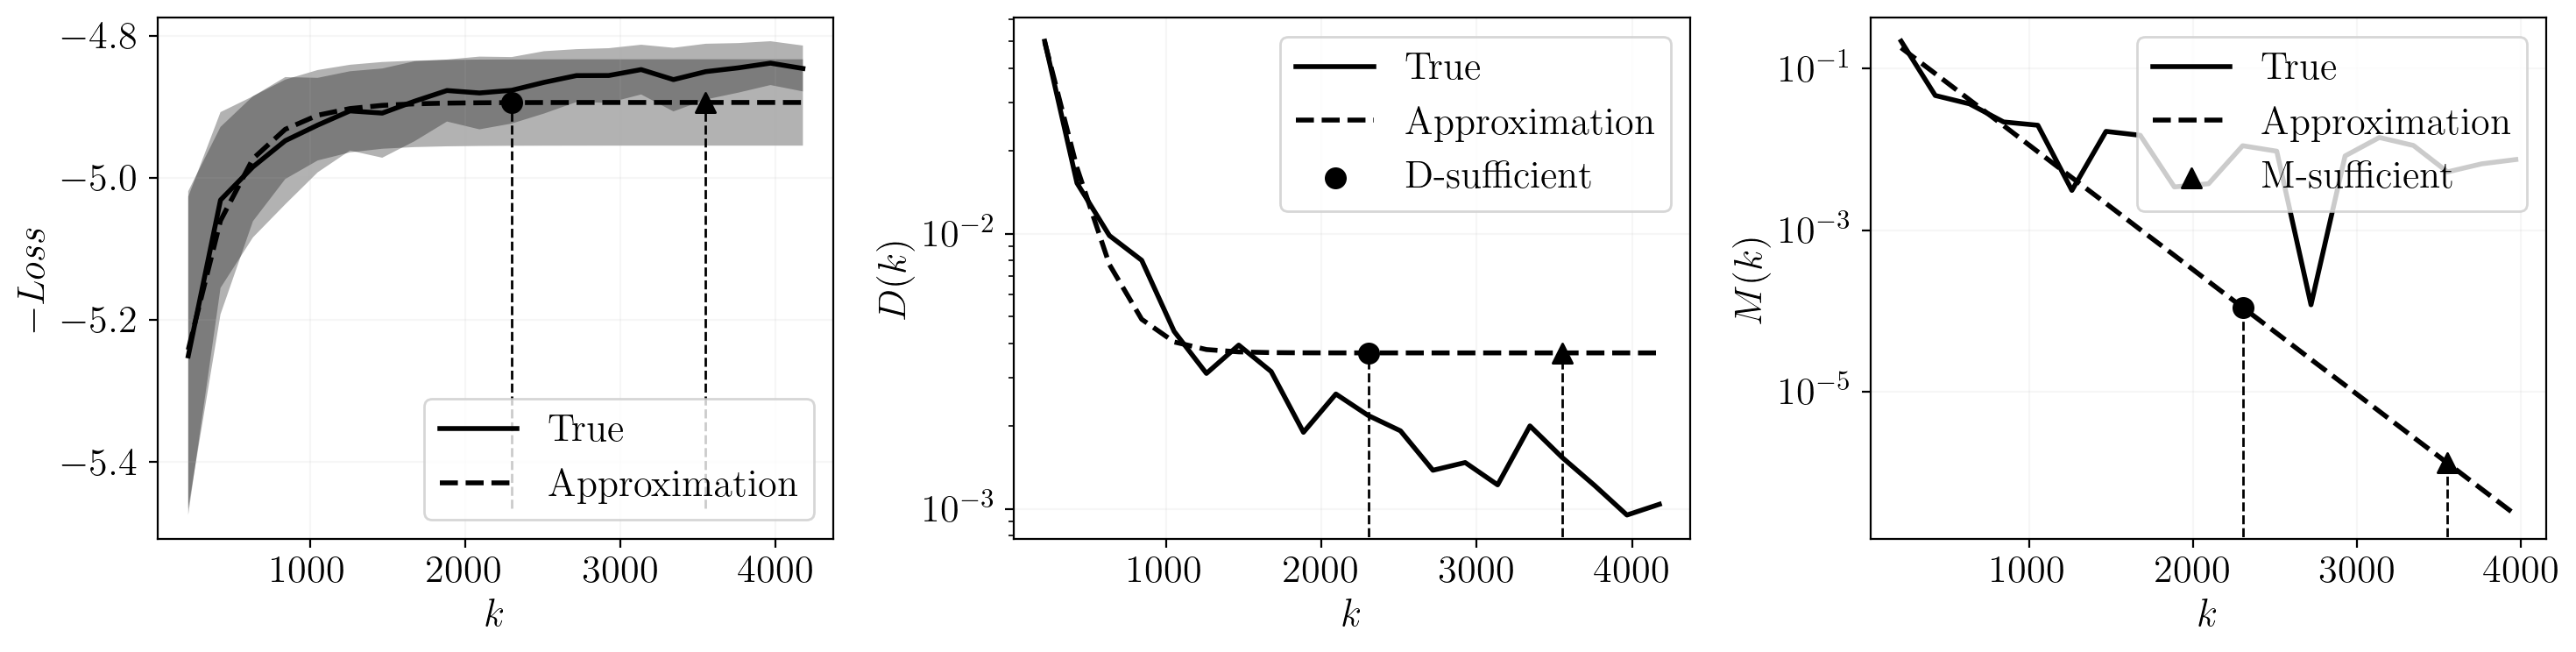

In [65]:
visualizer.plot_bootstrap_sufficient_approximation(estimator, forecaster, save=True, filename=figures_path+"abalone-approximation")